# Toy model for network curvature

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cartopy as ctp
import cartopy.crs as ccrs
import networkx as nx
from GraphRicciCurvature.FormanRicci import FormanRicci
from importlib import reload

from climnet.dataset import BaseDataset
from climnet.network import net, clim_networkx 
import climnet.grid as grid
import climnet.utils.spatial_utils as sput 
import climnet.plots as cplt
plt.style.use('paperplot.mplstyle')


In [2]:
# Parameters
grid_step = 5
save_folder =False # False or "../outputs/toyModel/"


In [3]:
# Create Grid
dist_equator = grid.degree2distance_equator(grid_step)
num_points = grid.get_num_points(dist_equator)
feketeGrid = grid.FeketeGrid(num_points=num_points,
                             num_iter=100,
                            pre_proccess_type=None)
# Grid to dataarray
da_grid = xr.DataArray(data=np.ones(num_points),
                       dims=['points'],
                       coords=dict(
                           points=np.arange(0, num_points, 1),
                           lon=("points", feketeGrid.grid['lon']),
                           lat=("points", feketeGrid.grid['lat']))
                       )


Create Fekete grid with 1483 points with 100 iterations.
Initial configuration not provided. Generating random one ...


Estim100%|██████████████████████████████| 100/100 [00:09<00:00, 10.19it/s]

... Finished


In [4]:
# Location of communities on the map
da_grid_comm = [
    sput.get_locations_in_range(da_grid, lon_range=[60, 120], lat_range=[30,60]),
    sput.get_locations_in_range(da_grid, lon_range=[110, 150], lat_range=[-40,-10]),
    sput.get_locations_in_range(da_grid, lon_range=[-120, -80], lat_range=[30,60]),
    sput.get_locations_in_range(da_grid, lon_range=[-80, -40], lat_range=[-30, 0])]

comm_sizes = [np.count_nonzero(~np.isnan(da)) for da in da_grid_comm]
comm_idx_grid = np.concatenate([np.where(da.data == 1)[0] for da in da_grid_comm])
print("Community size:", comm_sizes)

Community size: [44, 38, 31, 41]


Create a random graph using stochasic block modeling with four communities:

In [5]:
# Create Stochastic Block model
probs = [[0.7, 0.02, 0.02, 0.03], 
         [0.02, 0.6, 0.02, 0.01], 
         [0.02, 0.02, 0.6, 0.02],
         [0.03, 0.01, 0.02, 0.7]]
G_sbm = nx.stochastic_block_model(comm_sizes, probs, seed=0)
G_sbm.remove_edges_from(nx.selfloop_edges(G_sbm))
A_sbm = nx.adjacency_matrix(G_sbm).todense()

/tmp/ipykernel_66358/1136695948.py:8: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A_sbm = nx.adjacency_matrix(G_sbm).todense()


/tmp/ipykernel_66358/3630946537.py:5: RuntimeWarning: covariance is not positive-semidefinite.
  X_gauss = np.random.multivariate_normal(mean, cov, length)


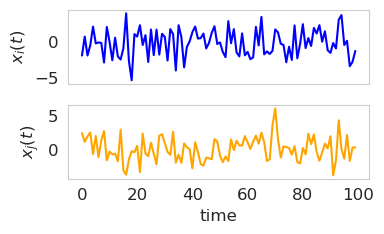

In [6]:
# Create data from Gaussian
length = int(1e3)
mean = np.zeros(A_sbm.shape[0])
cov = 1.0 * A_sbm
X_gauss = np.random.multivariate_normal(mean, cov, length)

# Plot sample
n_steps=100
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(4, 2.5))
axs[0].plot(X_gauss[:n_steps,np.random.randint(X_gauss.shape[1])], color='b')
axs[0].set_ylabel(r'$x_i(t)$')
axs[1].plot(X_gauss[:n_steps,np.random.randint(X_gauss.shape[1])], color='orange')
axs[1].set_ylabel(r'$x_j(t)$')
axs[1].set_xlabel('time')

if save_folder:
    plt.savefig(save_folder + "/random_ts.png", bbox_inches='tight')

In [7]:
# Create Dataset and store to file
da_gauss = xr.DataArray(
    data=X_gauss,
    dims=['time', 'points'],
    coords=dict(
        time=np.arange(length),
        points=da_grid['points'][comm_idx_grid].data,
        lon=("points", da_grid['lon'][comm_idx_grid].data),
        lat=("points", da_grid['lat'][comm_idx_grid].data)
    ),
    name='x'
)
ds_gauss = da_gauss.to_dataset()
param_class = {
     "grid_step": grid_step,
     "grid_type": 'fekete',
     "lsm": int(0),
     "q": 0,
     "min_evs": 0,
     "min_threshold": 0,
     "th_eev": 0,
     "th": 0,
     "an": 0 
 }
ds_gauss.attrs = param_class

# Save to file
fname = "../outputs/toyData.nc"
ds_gauss.to_netcdf(fname)

In [8]:
# Create BaseDataset object and save to file
ds = BaseDataset(var_name='x', load_nc=fname)

Load Dataset: toyData.nc
Variables in dataset:  x


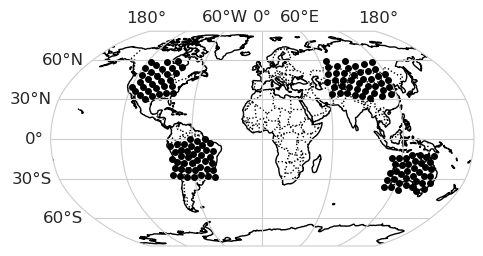

In [9]:
im = cplt.plot_map(ds, xr.where(ds.ds['x'][0], 1, 1), projection='Robinson', central_longitude=0, vmin=0, vmax=1,
                   plot_type='points', plt_grid=True, figsize=(5,3), size=4, marker='o', color='k', bar=False)
im['ax'].set_global()

if save_folder:
    plt.savefig(save_folder + "/points_on_map.png", bbox_inches='tight')

In [10]:
# Create Correlation Climnet
Net = net.CorrClimNet(ds, corr_method='spearman', significance_test=None,
                      threshold=0.11)
Net.create()
# Create NetworkX class
cnx = clim_networkx.Clim_NetworkX(dataset=ds,
                                  network=Net)

The number of non-zero datapoints 154 should approx. be 154.
(1000, 154)
Created spearman correlation matrix of shape (154, 154)
Created spearman correlation matrix of shape (154, 154)
No significance test used!
Created adjacency matrix.
No isolated nodes anymore!


100%|██████████| 154/154 [00:00<00:00, 2497.12it/s]

DiGraph with 154 nodes and 4524 edges
Sparsity of adjacency:  0.19075729465339855
Node attributes: ['lon', 'lat']
Edge attributes: ['weight']


In [11]:
# Compute curvature and betweenness
cnx.compute_curvature(c_type='forman')
cnx.compute_network_attrs('betweenness')



===== Compute the Forman Ricci curvature of the given graph =====
Forman curvature (augmented) computation done.
time elapsed: 0.08426499366760254
Compute Betweenness...
Create ds for all attributes present in node 0.


### Compare Gaussian sampled and SBM networks

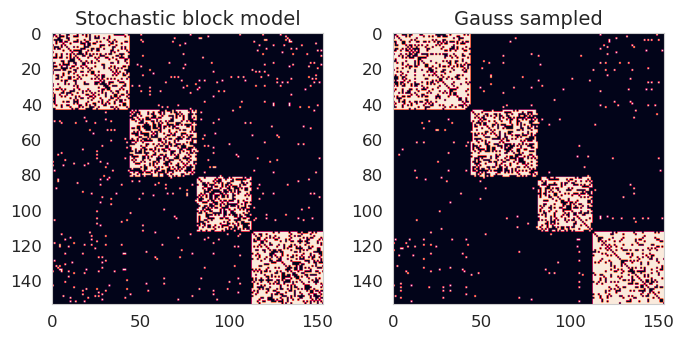

In [12]:
# Compare adjacency
fig, axs = plt.subplots(1, 2, figsize=(7,4))
axs[0].imshow(A_sbm)
axs[0].set_title("Stochastic block model")
axs[1].imshow(Net.adjacency)
axs[1].set_title("Gauss sampled")
if save_folder:
    plt.savefig(save_folder + "/compare_adjacencies.png", bbox_inches='tight')

In [13]:
# Curvature and betweenness of SBM Graph
frc = FormanRicci(G_sbm, verbose="INFO")
frc.compute_ricci_curvature()
ebc = nx.edge_betweenness_centrality(G_sbm, weight="weight")
nbc = nx.betweenness_centrality(G_sbm, weight="weight")


Forman curvature (augmented) computation done.


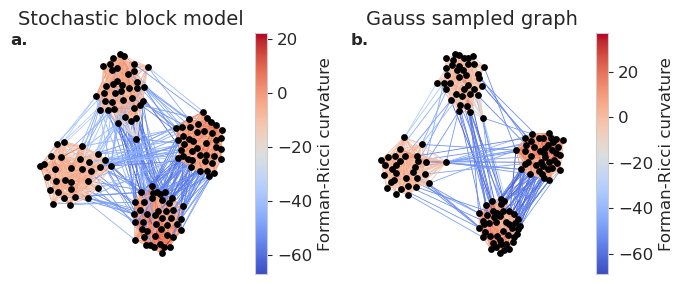

In [14]:
# Plot Forman Curvature in spring layout
plt.figure(figsize=(7, 3))
# SBM graph 
ax = plt.subplot(121)
ax.set_title("Stochastic block model")
colors = [frc.G[u][v]['formanCurvature'] for u, v in frc.G.edges]
vmin = min(colors)
vmax = max(colors)

cmap = cm.coolwarm
my_pos = nx.spring_layout(G_sbm, seed = 32)
nx.draw(G_sbm, pos=my_pos, edge_color=colors, edge_cmap=cmap, vmin=vmin,
        vmax=vmax, width=.6, node_size=15, node_color='k')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cb = plt.colorbar(sm, label='Forman-Ricci curvature')
cb.ax.tick_params(labelsize=12)
ax.text(-0.05, 0.95, f"a.", transform=ax.transAxes, weight='bold')

ax = plt.subplot(122)
ax.set_title("Gauss sampled graph")
colors = [cnx.cnx[u][v]['formanCurvature'] for u, v in cnx.cnx.edges]
vmin = min(colors)
vmax = max(colors)

cmap = cm.coolwarm
cnx_pos = nx.spring_layout(cnx.cnx, seed = 32)
nx.draw(cnx.cnx, pos=cnx_pos, edge_color=colors, edge_cmap=cmap, vmin=vmin,
        vmax=vmax, width=.6, node_size=15, node_color='k')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cb = plt.colorbar(sm, label='Forman-Ricci curvature')
cb.ax.tick_params(labelsize=12)
ax.text(-0.05, 0.95, f"b.", transform=ax.transAxes, weight='bold')

if save_folder:
    plt.savefig(save_folder + "/compare_springLayout_sbm_gauss.png", bbox_inches='tight')


### Plot on map

number of edges: 2262


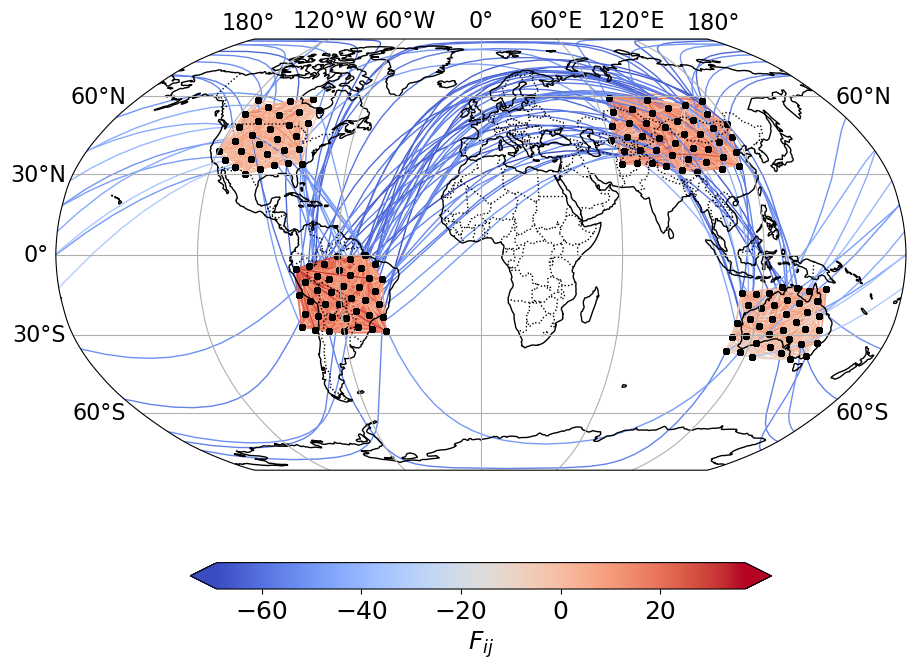

In [42]:
# Plot edge curvature on graph
reload(cplt)
edgeCurvature = cnx.get_edge_attr_dict('formanCurvature')
el = list(edgeCurvature.keys())
curv = list(edgeCurvature.values())

im = cplt.plot_edges(ds, list(el),
                weights=curv,
                vmin=np.min(curv), vmax=np.max(curv),
                color='coolwarm',
                projection='Robinson',
                central_longitude=0,
                plt_grid=True,
                lw=1.0,
                alpha=1.0,
                plot_points=True,
                marker='o', markersize=15, markercolor='k',
                figsize=(15,8),
                kwargs_cb=dict(orientation='horizontal', shrink=0.5, extend='both', 
                               label=r'$F_{ij}$',
                               #ticks=np.linspace(int(np.min(curv)), int(np.max(curv)), 5)
                )
)
im['ax'].set_global()
#plt.tight_layout()

if save_folder:
    plt.savefig(save_folder + "/graph_on_map.png", bbox_inches='tight')

In [16]:
# Normalize curvature
cnx.normalize_edge_attr(attributes=['formanCurvature'])

# Get quantiles
q_vals = [0.8, 0.2]
_ = cnx.get_node_attr_q(
    edge_attrs=['formanCurvature',
                'formanCurvature_norm'],
    q_values=q_vals, norm=True
)

Store normalized formanCurvature in network.
formanCurvature
Get node attr formanCurvature_norm...
formanCurvature_norm: No nans in nodes, nothing to correct!
Create ds for all attributes present in node 0.
formanCurvature
0.8
Get values 0.8 <= 15.0
0.2
Get values 0.2 <= -2.0
formanCurvature_norm
0.8
Get values 0.8 <= 0.5849056603773586
0.2
Get values 0.2 <= 0.26415094339622636
Create ds for all attributes present in node 0.


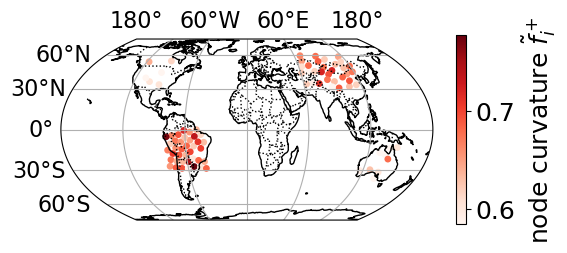

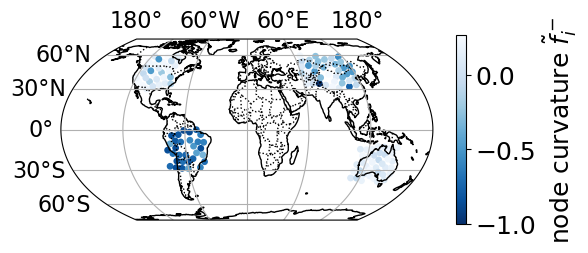

In [35]:
vars = [
    dict(var=f'formanCurvature_norm_q{q_vals[0]}',
         vmin=None,
         vmax=None,
         cmap='Reds', label=r"$\tilde{f}_i^+$"),
    dict(var=f'formanCurvature_norm_q{q_vals[1]}',
         vmin=None,
         vmax=None,
         cmap='Blues_r', label=r"$\tilde{f}_i^-$"),
]

for i, v in enumerate(vars):
    fig = plt.figure(figsize=(6,3.5))
    ax = fig.add_subplot(1,1,1,
                            projection=ccrs.EqualEarth(central_longitude=0))
    im = cplt.plot_map(ds, cnx.ds_nx[v['var']],
                  ax=ax,
                  plot_type='scatter',
                  cmap=v['cmap'],
                  projection='PlateCarree',
                  plt_grid=True,
                  vmin=v['vmin'],
                  vmax=v['vmax'],
                  central_longitude=0,
                  size=15, marker='o',
                  bar=False
                  )
    ax.set_global()
    
    cbar = fig.colorbar(
        im['im'],
        ax=ax,
        orientation='vertical',
        label=f"node curvature {v['label']}",
        shrink=0.7
    )

    if save_folder:
        plt.savefig(save_folder + f"/node_{v['var']}_map.svg", bbox_inches='tight')

## Compare to betweenness centrality

number of edges: 2262
number of edges: 2262


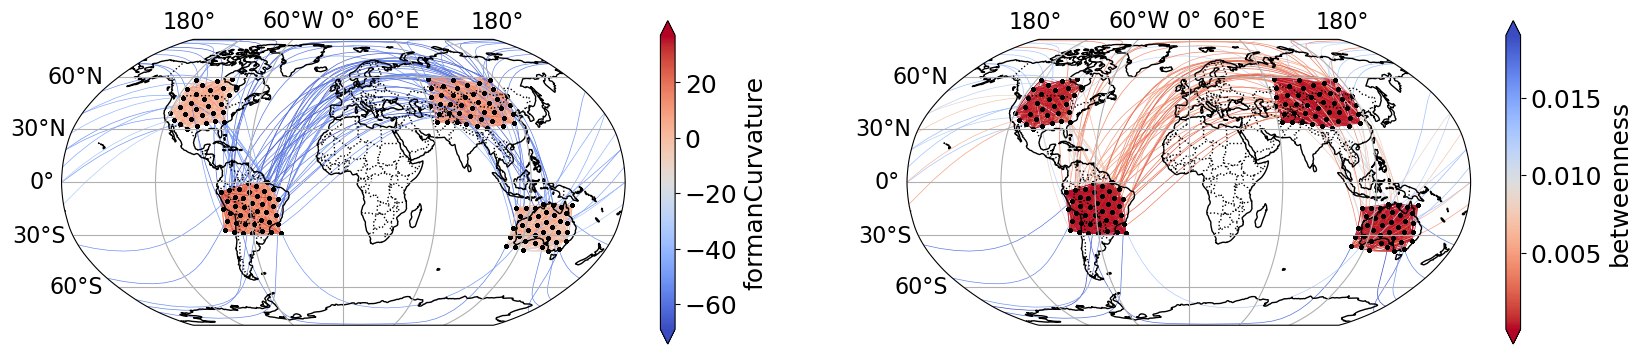

In [18]:
reload(cplt)

fig = plt.figure(figsize=(20, 7))
for i, var in enumerate(['formanCurvature', 'betweenness']):
    edge_attr = cnx.get_edge_attr_dict(var)
    el = list(edge_attr.keys())
    attr = list(edge_attr.values())

    ax = fig.add_subplot(1,2,i+1, projection=ctp.crs.Robinson())
    if var == 'betweenness':
        cmap = 'coolwarm_r'
    else:
        cmap = 'coolwarm'
    im = cplt.plot_edges(ds, list(el),
                    weights=attr,
                    ax=ax,
                    color=cmap,
                    projection='Robinson',
                    central_longitude=0,
                    plt_grid=True,
                    lw=0.5,
                    alpha=1.0,
                    plot_points=True,
                    markersize=4,
                    markercolor='k',
                    kwargs_cb=dict(orientation='vertical', shrink=0.6, extend='both', 
                                   label=var,
                                   #ticks=np.linspace(int(np.min(curv)), int(np.max(curv)), 5)
                    )
    )
    ax.set_global()


if save_folder:
    plt.savefig(save_folder + "/betweenness_vs_curvature.png", bbox_inches='tight')

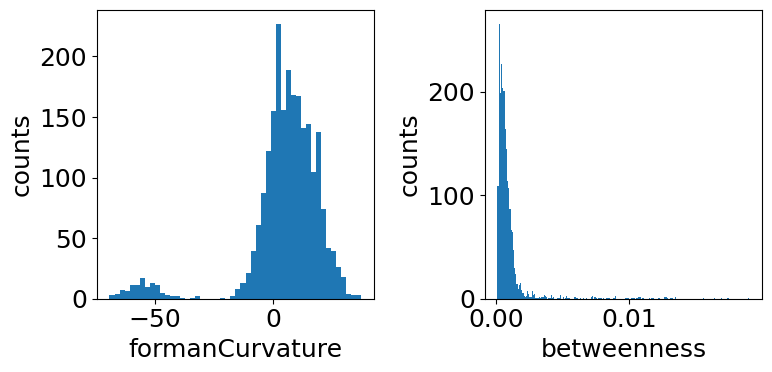

In [34]:
# Histograms
fig, axs = plt.subplots(1,2, figsize=(8,4))
for i, var in enumerate(['formanCurvature', 'betweenness']):
    edge_attr = cnx.get_edge_attr_dict(var)
    el = list(edge_attr.keys())
    attr = list(edge_attr.values())
    axs[i].hist(attr, bins='auto')
    axs[i].set_xlabel(var)
    axs[i].set_ylabel('counts')
    
plt.tight_layout()
if save_folder:
    plt.savefig(save_folder + "/betweenness_vs_curvature_hist.png", bbox_inches='tight')

## Edge plot with colored curvature on Orthographic plot

In [ ]:
# Plot edge curvature on Orthographic map
edgeCurvature = cnx.get_edge_attr_dict('formanCurvature')
el = list(edgeCurvature.keys())
curv = list(edgeCurvature.values())

im = cplt.plot_edges(ds, list(el),
                weights=curv,
                vmin=np.min(curv), vmax=np.max(curv),
                color='coolwarm',
                projection='Orthographic',
                central_longitude=120,
                plt_grid=False,
                lw=0.7,
                alpha=0.8,
                plot_points=True,
                markersize=3,
                markercolor='k',
                figsize=(7,4),
)
im['ax'].set_global()

if save_folder:
    plt.savefig(save_folder + "/graph_on_map.png", bbox_inches='tight')